## [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
- "Naive" = assumes conditional _independence_ between every pair of features for a given class variable.
- Bayes Theorem defined as: $P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots, x_n \mid y)}
                                 {P(x_1, \dots, x_n)}$
- Bayes classifiers differ mainly by their assumptions about the distribution of $P(x_i \mid y)$.
- Well known & often used for text doc classification & spam filtering.
- Can be extremely fast -- decoupling class-conditional feature distributions means that each distribution can be _independently evaluated_ as a 1D function. This therefore sidesteps curse-of-dimensionality problems.
- Not good as an estimator. The probability outputs (```predict_proba```) are not reliable.

## [Gaussian NB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

In [1]:
from sklearn.datasets        import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes     import GaussianNB

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

gnb    = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print("#Mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

#Mislabeled points out of a total 75 points : 4


## [Multinomial NB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)
- Distribution described as a set of vectors $\theta_y = (\theta_{y1},\ldots,\theta_{yn})$ for each class_y_; _n_ = the number of features (in text = vocobular size).
- The params are are estimated using a smoothed version of max likelihood, aka relative frequency counting: $\hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n}$

In [2]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB

rng = np.random.RandomState(1)
X   = rng.randint(5, size=(6, 100))
y   = np.array([1, 2, 3, 4, 5, 6])
clf = MultinomialNB()

clf.fit(X, y)
print(clf.predict(X[2:3]))

[3]


## [Complement NB (CNB)](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB)

- CNB = adaptation of multinomial NB for _imbalanced datasets_. It uses statistics from each class's complement to find the model weights.
- CNB often outperforms MNB on text classification
- Weights are found using: $ \begin{align}\begin{aligned}\hat{\theta}_{ci} = \frac{\alpha_i + \sum_{j:y_j \neq c} d_{ij}}
                         {\alpha + \sum_{j:y_j \neq c} \sum_{k} d_{kj}}\\w_{ci} = \log \hat{\theta}_{ci}\\w_{ci} = \frac{w_{ci}}{\sum_{j} |w_{cj}|}\end{aligned}\end{align}$


In [3]:
import numpy as np
from sklearn.naive_bayes import ComplementNB

rng = np.random.RandomState(1)
X   = rng.randint(5, size=(6, 100))
y   = np.array([1, 2, 3, 4, 5, 6])
clf = ComplementNB()

clf.fit(X, y)
print(clf.predict(X[2:3]))

[3]


## [Bernoulli NB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)
- Implements NB training for multivariate Bernoulli distributions (multiple binary-valued features)
- Requires samples to be coded as binary-valued feature vectors.
- Decision rule: $P(x_i \mid y) = P(i \mid y) x_i + (1 - P(i \mid y)) (1 - x_i)$


In [4]:
rng = np.random.RandomState(1)
from sklearn.naive_bayes import BernoulliNB

X = rng.randint(5, size=(6, 100))
Y = np.array([1, 2, 3, 4, 4, 5])
clf = BernoulliNB()

clf.fit(X, Y)
print(clf.predict(X[2:3]))

[3]


## [Categorical NB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB)
- Assumes each feature _i_ has its own distribution.
- The probability of category _t_ in feature _i_, given class _c_, is estimated as $P(x_i = t \mid y = c \: ;\, \alpha) = \frac{ N_{tic} + \alpha}{N_{c} +
                                       \alpha n_i},$
- Assumes X all categories for each feature _i_ are numerically encoded as $0, ..., n_i - 1$

In [5]:
import numpy as np
from sklearn.naive_bayes import CategoricalNB

rng = np.random.RandomState(1)
X = rng.randint(5, size=(6, 100))
y = np.array([1, 2, 3, 4, 5, 6])
clf = CategoricalNB()
clf.fit(X, y)
print(clf.predict(X[2:3]))

[3]


## Out of Core NB model fitting
- NB models can be used to handle classification problems that cannot fit in main memory. Multinomial, Bernoulli & Gaussian NB classes have a ```partial_fit``` method to aid this approach.
- See [Scikit-learn scaling strategies](https://scikit-learn.org/stable/modules/computing.html#scaling-strategies) for more info.

In [6]:
from glob import glob
import itertools, os.path, re, tarfile, time, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from html.parser import HTMLParser
from urllib.request import urlretrieve
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

In [7]:
# download Reuters-21578 dataset from UCI repo
class ReutersParser(HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""

# Iterate over doc in Reuters dataset.
# auto-downloaded and uncompressed if `data_path` does not exist.
# documents represented as dictionaries with 'body','title','topics' keys.

def stream_reuters_documents(data_path=None):
    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                sys.stdout.write(
                    '\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb))

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path,
                    reporthook=progress)
        if _not_in_sphinx():
            sys.stdout.write('\r')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

In [8]:
vectorizer = HashingVectorizer(
    decode_error='ignore', 
    n_features=2 ** 18,
    alternate_sign=False)

data_stream = stream_reuters_documents()

# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.

all_classes = np.array([0, 1])
positive_class = 'acq'
partial_fit_classifiers = {
    'SGD': SGDClassifier(max_iter=5),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}


In [9]:
# extract minibatch of samples - return tuple of X_text, y.

def get_minibatch(doc_iter, size, pos_class=positive_class):

    data = [('{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)

In [10]:
# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents          = 1000
tick                      = time.time()
X_test_text, y_test       = get_minibatch(data_stream, 1000)
parsing_time              = time.time() - tick
tick                      = time.time()
X_test                    = vectorizer.transform(X_test_text)
vectorizing_time          = time.time() - tick
test_stats['n_test']     += len(y_test)
test_stats['n_test_pos'] += sum(y_test)

print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))

def progress(cls_name, stats):
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s

cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set
# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.

minibatch_size = 1000

# Create data_stream that parses Reuters SGML files and iterates on
# documents as a stream.

minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batches of examples

for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')

Test set is 986 documents (159 positive)
                 SGD classifier : 	   966 train docs (    88 positive)    986 test docs (   159 positive) accuracy: 0.866 in 0.80s ( 1208 docs/s)
          Perceptron classifier : 	   966 train docs (    88 positive)    986 test docs (   159 positive) accuracy: 0.880 in 0.81s ( 1196 docs/s)
      NB Multinomial classifier : 	   966 train docs (    88 positive)    986 test docs (   159 positive) accuracy: 0.840 in 0.86s ( 1127 docs/s)
  Passive-Aggressive classifier : 	   966 train docs (    88 positive)    986 test docs (   159 positive) accuracy: 0.897 in 0.86s ( 1120 docs/s)


                 SGD classifier : 	  3875 train docs (   491 positive)    986 test docs (   159 positive) accuracy: 0.935 in 2.51s ( 1546 docs/s)
          Perceptron classifier : 	  3875 train docs (   491 positive)    986 test docs (   159 positive) accuracy: 0.881 in 2.51s ( 1543 docs/s)
      NB Multinomial classifier : 	  3875 train docs (   491 positive)    986 tes

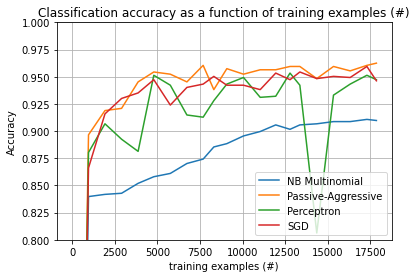

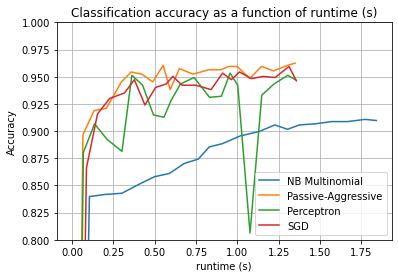

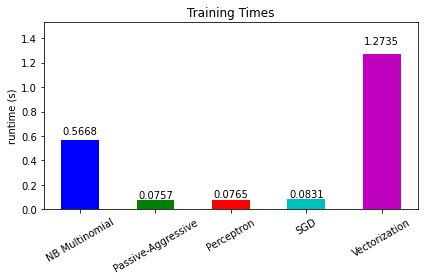

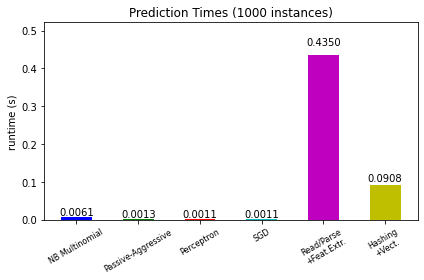

In [11]:
# plot classifier learning curve over the accumulation of mini-batches
# accuracy measured on first 1K samples, held out as a validation set.
# samples are queued to a fixed amount before feeding them to the learner,
# as a memory consumption limited.

def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)


rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = [stats['total_fit_time']
               for cls_name, stats in sorted(cls_stats.items())]

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors = ['b', 'g', 'r', 'c', 'm', 'y']

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')
        plt.setp(plt.xticks()[1], rotation=30)


autolabel(rectangles)
plt.tight_layout()
plt.show()

# Plot prediction times
plt.figure()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('Hashing\n+Vect.')

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.tight_layout()
plt.show()